# Title

**Group Participants:** Subodhee Kaluarachchi (22323646), Haiyu Long (62509666), Tyson Hutt (55249007)

# Introduction

Minecraft is a popular 3D sandbox game where the objective is to survive, collect resources, and explore the endless world made of blocks. A study conducted by a computer science research group at UBC (insert in-text citation) collected data on the Minecraft playing practices and statistics of 196 participants, including their experience level, subscription status, hashed email, total played hours, name, gender, and age *(Figure 1)*. Our analysis aims to address whether the player’s gaming experience, their subscription status to the game-related newsletter, and age are useful predictors to determine their total hours of play.

| Name of Variable |  Type  |  Meaning  |
|:----------------:|:------:|:---------:|
|  experience      |  fct   | Describes how comfortable/knowledgeable the player is with MineCraft |
|  subscribe       |  lgl   | Whether they are subscribed to a game-related newsletter or not      |
|  hashedEmail     |  chr   | Their email in hashed format                                         |
|  played_hours    |  dbl   | The amount of hours they played, up to 1 decimal                     |
|  name            |  chr   | The player's first name                                              |
|  gender          |  fct   | The player's gender                                                  |
|  Age             |  int   | The player's age                                                     |

**Figure 1:** Description of the variables present in players.csv

### **Question:** Will the players' gaming experience, whether or not they subscribe to the game-related newsletter, and age become useful predictors for their total hours of playing?

# Methods & Results

## Data Preprocessing and Summary

In [13]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

players_raw <- read_csv("https://raw.githubusercontent.com/ryyuerber/DSCI100_Group_26_Final_Proj/refs/heads/main/players.csv") |>
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE")) |>
    select(-hashedEmail, -name)
players_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,Age
<fct>,<fct>,<dbl>,<chr>,<dbl>
Pro,Yes,30.3,Male,9
Veteran,Yes,3.8,Male,17
Veteran,No,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Amateur,No,0.0,Prefer not to say,17
Amateur,No,2.3,Male,17
Pro,Yes,0.2,Other,NA


In [18]:
players_na_sum <- colSums(is.na(players_raw))

players_zeros <- players_raw |>
    filter(played_hours == 0) |>
    summarize(count = n())

hours_played_summary <- players_raw |> summarize(played_hours_min = min(played_hours, na.rm = TRUE),
    played_hours_max = max(played_hours),
    played_hours_mean = mean(played_hours),
    played_hours_median = median(played_hours),
    played_hours_sd = sd(played_hours))

age_summary <- players_raw |> summarize(age_min = min(Age, na.rm = TRUE),
    age_max = max(Age, na.rm = TRUE),
    age_mean = mean(Age, na.rm = TRUE),
    age_median = median(Age, na.rm = TRUE))

ctg_summary <- players_raw |>
  select(experience, subscribe, gender) |>
  pivot_longer(cols = experience:gender, names_to = "Column", values_to = "categories") |>
  group_by(Column, categories) |>
  summarize(Count = n())

players_na_sum
players_zeros
hours_played_summary
age_summary
print(ctg_summary)

`summarise()` has grouped output by 'Column'. You can override using the
`.groups` argument.


experience    subscribe played_hours       gender          Age 
           0            0            0            0            2

count
<int>
85


played_hours_min,played_hours_max,played_hours_mean,played_hours_median,played_hours_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,223.1,5.845918,0.1,28.35734


age_min,age_max,age_mean,age_median
<dbl>,<dbl>,<dbl>,<dbl>
8,50,20.52062,19


# A tibble: 14 × 3
# Groups:   Column [3]
   Column     categories        Count
   <chr>      <chr>             <int>
 1 experience Amateur              63
 2 experience Beginner             35
 3 experience Pro                  14
 4 experience Regular              36
 5 experience Veteran              48
 6 gender     Agender               2
 7 gender     Female               37
 8 gender     Male                124
 9 gender     Non-binary           15
10 gender     Other                 1
11 gender     Prefer not to say    11
12 gender     Two-Spirited          6
13 subscribe  No                   52
14 subscribe  Yes                 144


## Prior Visualizations

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


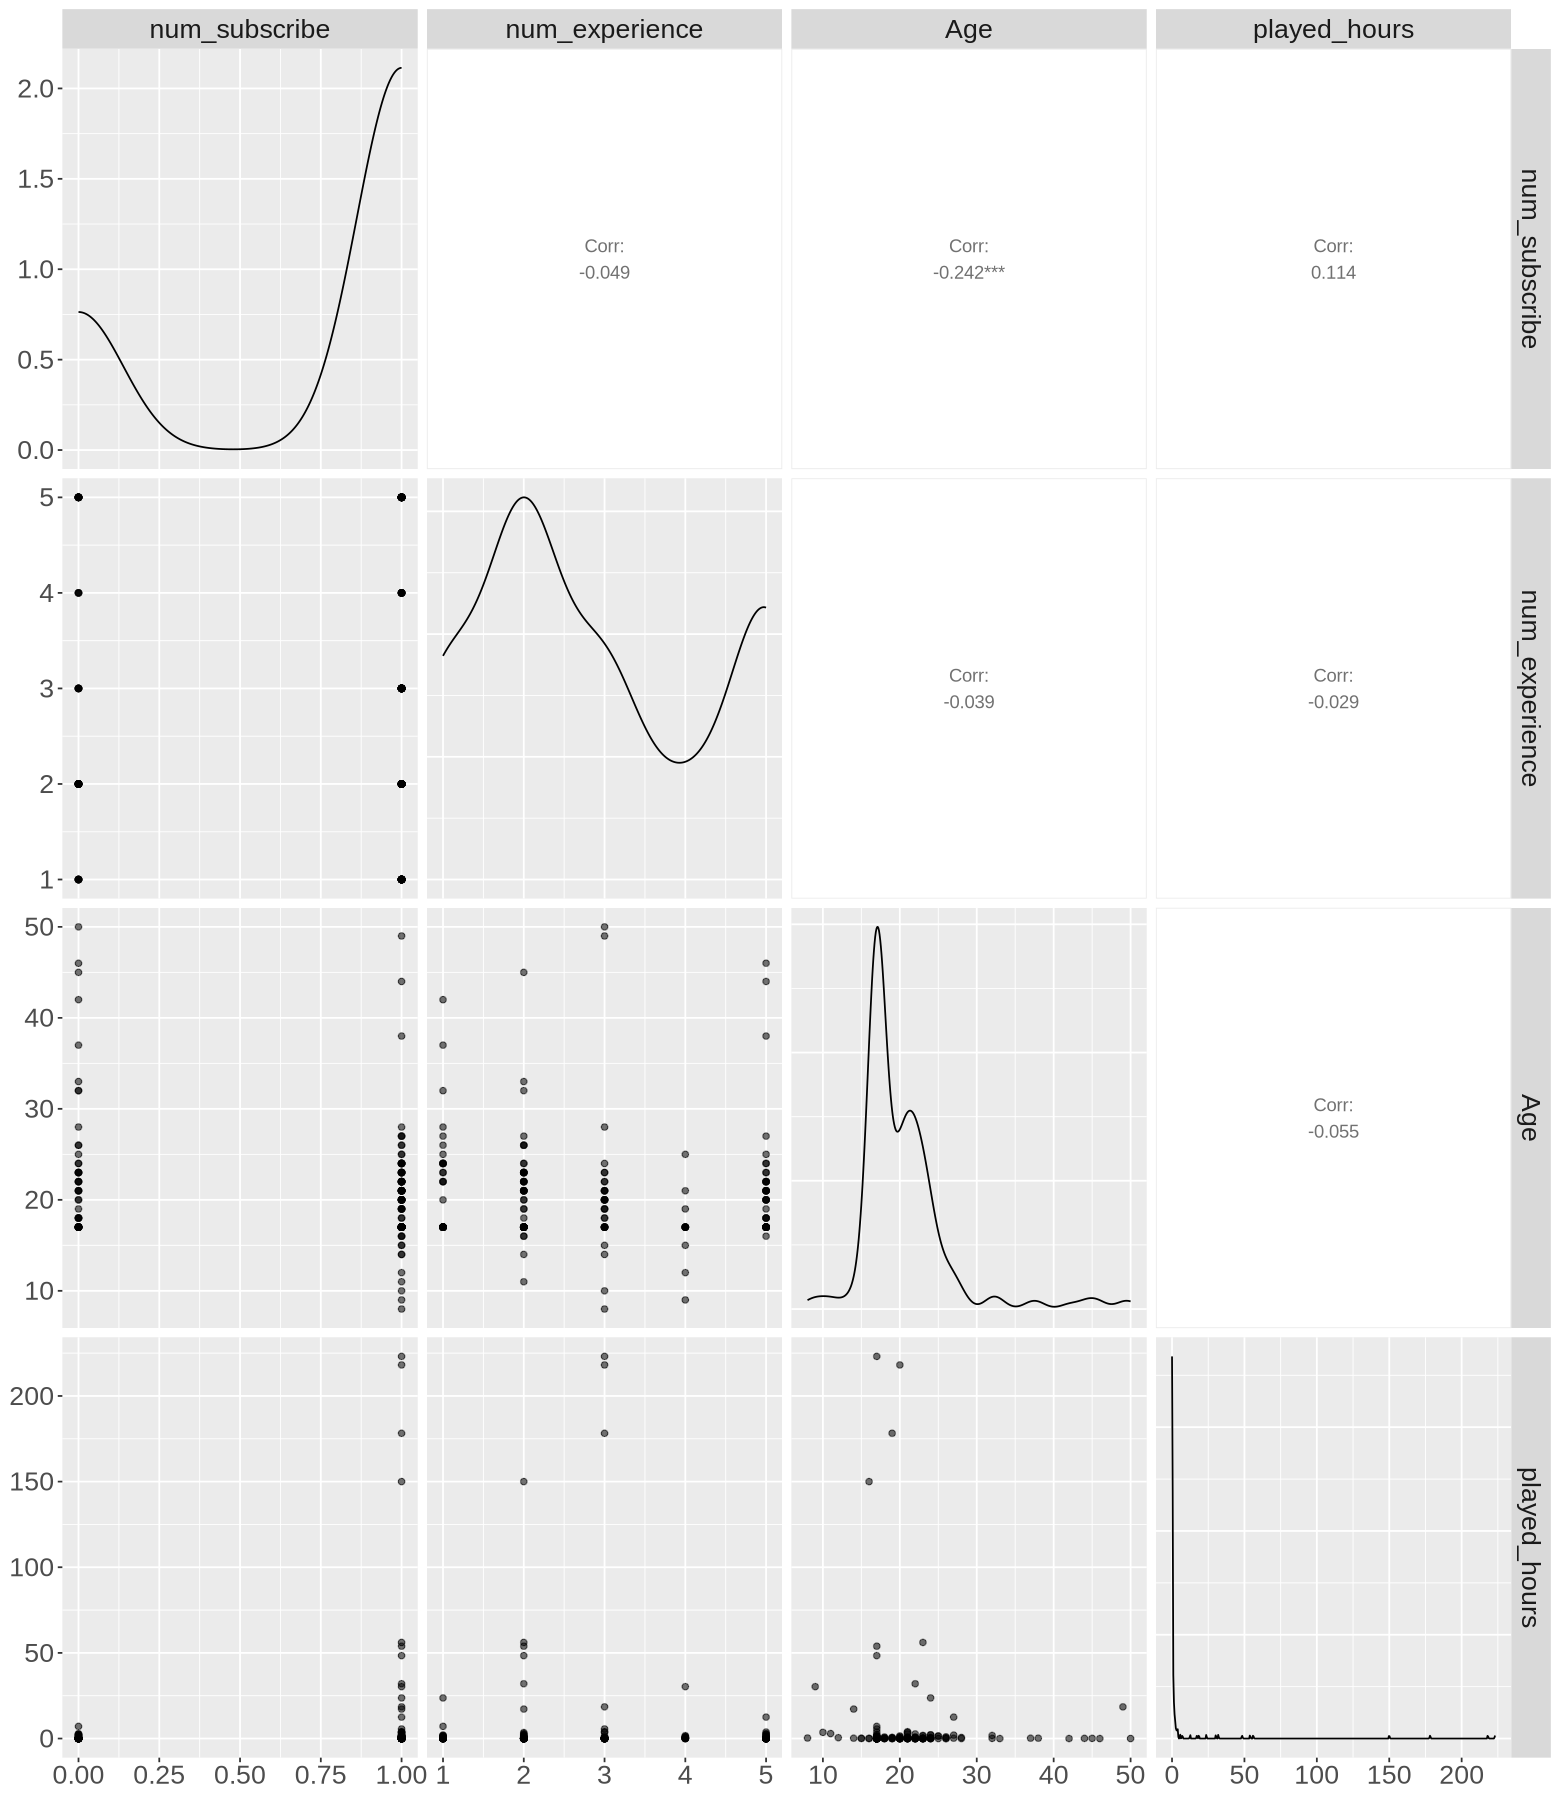

In [19]:
options(repr.plot.height = 15, repr.plot.width = 13)

credit_pairplot <- players_fn |> 
    select(num_subscribe, num_experience, Age, played_hours) |>
    ggpairs(mapping = aes(alpha = 0.3)) +
    theme(text = element_text(size = 20))
credit_pairplot

## Analysis

In [20]:
players_numericalized <- players_mdfied |> 
    mutate(num_subscribe = case_when(subscribe == 'Yes' ~ 1, subscribe == 'No' ~ 0)) |>
    mutate(num_experience = case_when(experience == 'Beginner' ~ 1, 
                                      experience == 'Amateur' ~ 2, 
                                      experience == 'Regular' ~ 3, 
                                      experience == 'Pro' ~ 4,
                                      experience == 'Veteran' ~ 5))

players_fn <- select(players_numericalized, Age, num_subscribe, num_experience, played_hours)

In [21]:
players_split <- initial_split(players_fn, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

lm_spec <- linear_reg() |>
    set_engine('lm') |>
    set_mode('regression')

players_recipe <- recipe(played_hours ~ ., data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

player_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(lm_spec) |>
    fit(data = players_training)

players_pred_train <- player_fit |>
        predict(players_training) |>
        bind_cols(players_training)

lm_rmse <- metrics(players_pred_train, truth = played_hours, estimate = .pred) |>
        filter(.metric == 'rmse') |>
        select(.estimate) |>
        pull()
lm_rmse
player_fit


[1] 26.70594

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_impute_mean()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
   (Intercept)             Age   num_subscribe  num_experience  
        5.4116         -0.7830          2.4757         -0.5113  


In [22]:
players_fn_nonzeros <- players_fn|>
    filter(played_hours != 0)
players_fn_nonzeros

players_split_2 <- initial_split(players_fn_nonzeros, prop = 0.75, strata = played_hours)
players_training_2 <- training(players_split_2)
players_testing_2 <- testing(players_split_2)

players_recipe_2 <- recipe(played_hours ~ ., data = players_training_2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

player_fit_2 <- workflow() |>
    add_recipe(players_recipe_2) |>
    add_model(lm_spec) |>
    fit(data = players_training_2)

players_pred_train_2 <- player_fit_2 |>
        predict(players_training_2) |>
        bind_cols(players_training_2)

lm_rmse_2 <- metrics(players_pred_train_2, truth = played_hours, estimate = .pred) |>
        filter(.metric == 'rmse') |>
        select(.estimate) |>
        pull()
lm_rmse_2
player_fit_2

Age,num_subscribe,num_experience,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
9,1,4,30.3
17,1,5,3.8
21,1,2,0.7
⋮,⋮,⋮,⋮
22,0,5,0.3
17,0,2,2.3
NA,1,4,0.2


[1] 41.7639

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_impute_mean()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
   (Intercept)             Age   num_subscribe  num_experience  
        12.637          -2.836           5.447          -1.058  


# Discussion

# References (If applicable)